# Travel Insurance Prediction Data Project

## 1. Introduction

**Context**

In 2019, a Tour & Travels company launched a new travel insurance package that included coverage for COVID-related risks. The company is now seeking to identify which customers are most likely to purchase this insurance based on historical data collected during the initial offering. This dataset includes information on nearly 2,000 previous customers, capturing a variety of demographic, financial, and behavioral features.

**Goals**

    To build a predictive model that accurately identifies customers who are likely to purchase a travel insurance package, enabling improved customer targeting and more effective marketing strategies.

**Objectives**

    Understand Customer Profiles: Analyze customer demographic and travel-related attributes to identify patterns associated with travel insurance purchasing behavior.
    
    Prepare and Model Data: Clean, preprocess, and engineer relevant features from the Kaggle travel insurance dataset to develop a classification model.
    
    Model Evaluation: Train and compare multiple machine learning algorithms to determine the best-performing model based on accuracy and other relevant evaluation metrics.
    
    Provide Actionable Insights: Translate model findings into meaningful insights that can guide targeted marketing strategies and personalized promotional offers.
    
    Scope Limitation: The model will use only the attributes available in the provided dataset and will focus on prediction and insights, not real-time deployment or pricing optimization.

**Dataset Overview**

The dataset contains 1987, 9 records of previous customers who were offered travel insurance in 2019. It includes 8 independent variables and 1 target variable (TravelInsurance).

## 2. Exploratory Data Analysis (EDA)

### A. Data loading & Initial checks

In [1]:
%load_ext jupyter_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import (
    levene,
    chi2_contingency,
    randint,
    uniform,
    shapiro,
    mannwhitneyu,
)
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_predict,
    cross_val_score,
)
from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
from Data.utils import (
    plot_distribution_numerical,
    stacked_bar_with_percent,
    crosstab_chi2_test,
    bootstrap_median_diff,
    plot_phik_correlation_heatmap,
)

In [4]:
df = pd.read_csv(r"Data\TravelInsurancePrediction.xls")
df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [5]:
df = df.drop(columns="Unnamed: 0")

In [6]:
df.shape

(1987, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


**Feature descriptions:**

Independent variables:
- Age- Age Of The Customer
- Employment Type- The Sector In Which Customer Is Employed
- GraduateOrNot- Whether The Customer Is College Graduate Or Not
- AnnualIncome- The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]
- FamilyMembers- Number Of Members In Customer's Family
- ChronicDisease- Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.
- FrequentFlyer- Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019].
- EverTravelledAbroad- Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]
  
Dependent variable:
- TravelInsurance- Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.

In [8]:
cat_features = df.select_dtypes(include="object").columns.tolist()
num_features = df.select_dtypes(exclude="object").columns.tolist()
print(f"Numerical features: {num_features}")
print(f"Categorical features: {cat_features}")

Numerical features: ['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases', 'TravelInsurance']
Categorical features: ['Employment Type', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']


**Checking for missing values.**

In [9]:
df.isna().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

No missing values in the dataset.

**Checking for duplicates.**

In [10]:
print(
    f"Duplicates: {df.duplicated().sum()}, {(df.duplicated().sum() / len(df) * 100):.2f}%"
)

Duplicates: 738, 37.14%


In [11]:
df_no_dupl = df.drop_duplicates()
df_no_dupl.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


**Comparing distributions with and without duplicates.**

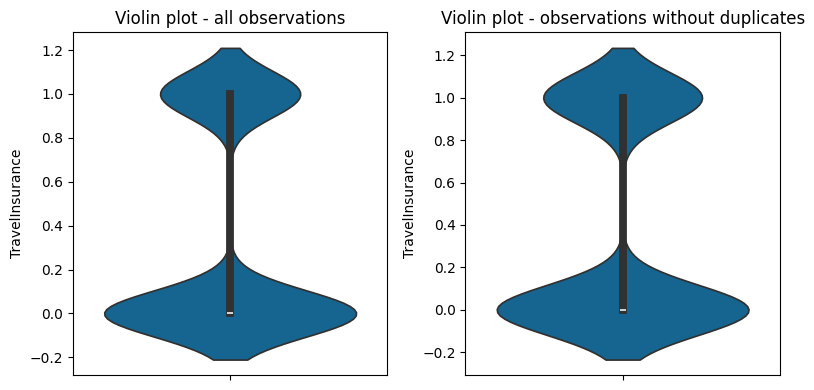

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.violinplot(y="TravelInsurance", data=df, ax=axes[0])
axes[0].set_title("Violin plot - all observations")
sns.violinplot(y="TravelInsurance", data=df_no_dupl, ax=axes[1])
axes[1].set_title("Violin plot - observations without duplicates")
plt.tight_layout()

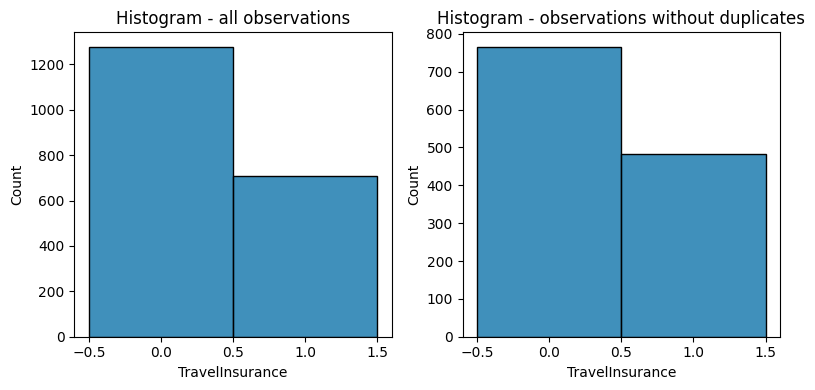

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(data=df, x="TravelInsurance", discrete=True, ax=axes[0])
axes[0].set_title("Histogram - all observations")
sns.histplot(data=df_no_dupl, x="TravelInsurance", discrete=True, ax=axes[1])
axes[1].set_title("Histogram - observations without duplicates")
plt.tight_layout()

The distributions appear very similar whether duplicates are included or not, but the distribusion without duplicates is less disbalanced.

The dataset lacks a customer ID, dates or time, we can't prove that duplicated are "bad".

Given the nature of our features, particularly that 'AnnualIncome' is recorded as discrete intervals (rounded to the nearest 50 thousand rupees), and 'Age' is also practically treated as discrete (whole years), duplicate rows may not necessarily represent identical individuals or errors in data collection.

The first project (peer review) was done on df_no_dupl, (even the distribusion without duplicates is less disbalanced) the calculation for tuned Random forest with duplicates showed better results comparing to no duplicates:

Recall (class 1) improved: 0.67 vs 0.56

Precision (class 1) improved: 0.94 vs 0.89

F1 (class 1) improved: 0.79 vs 0.69

Since duplicates improve buyer prediction performance (business objective is accurate buyer identification) I decided to keep duplicates in this project.

In [14]:
df.shape

(1987, 9)

In [15]:
df.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


Key insights:
- Age: Target young professionals (25–35 age group).
- Annual income: Middle-to-upper-middle-class customers. 600.000 - 1.200.000 rupees.
- Family members: Larger families (5+ members) are common.
- Chronic diseases: 27.8% customers has health risks.
- Travel insurance: Class Imbalance 35.7% buyers - need to use class weights or balanced metrics to avoid bias toward non-buyers.

### B. Univariate Analysis

**Distribution of target variable - TravelInsurance.**

In [16]:
insurance_counts = df["TravelInsurance"].value_counts()
insurance_counts

TravelInsurance
0    1277
1     710
Name: count, dtype: int64

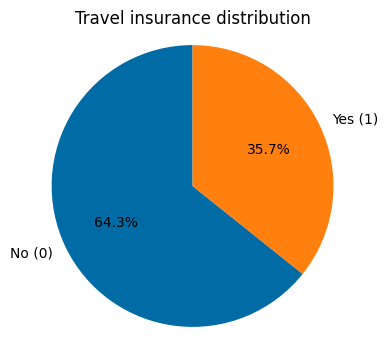

In [17]:
labels = ["No (0)", "Yes (1)"]

plt.figure(figsize=(4, 4))
plt.pie(
    insurance_counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Travel insurance distribution")
plt.axis("equal")
plt.show()

Moderate imbalance 35.7% buyers and 64.3% non-buyers. 35.7% conversion rate is relatively high for insurance products (average conversion rate for the insurance industry is about 9% https://askwonder.com/research/average-lead-generation-rates-insurance-financial-services-automotive-technology-dzuxupyka)

35.7% conversion rate is 4x higher than industry average (9%) it suggests existing data is biased toward likely buyers (e.g., frequent travelers, higher income).

This suggests the existing customer base is receptive, but markating can be optimized further by targeting high-probability customers using predictive models.

**Distribution plots for numerical features.**

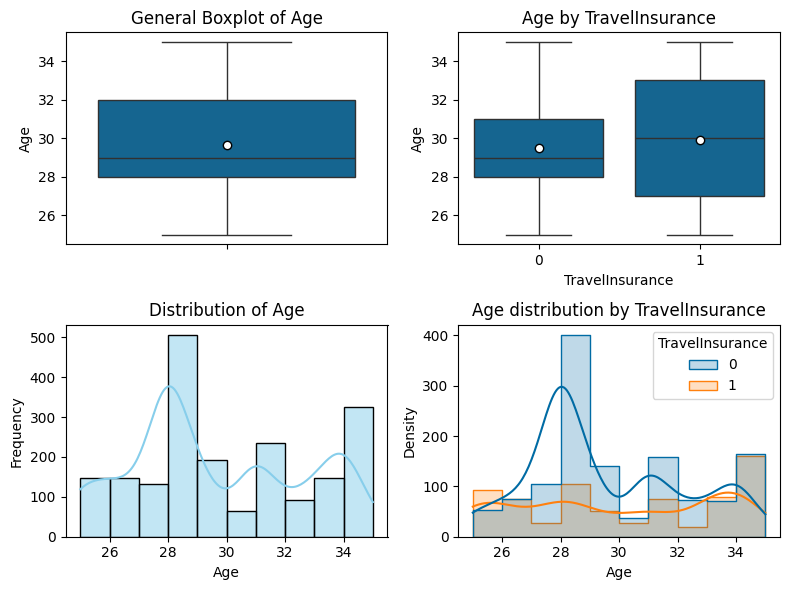

In [5]:
plot_distribution_numerical(df, "Age")

Age distribusions are not normal, minimum 25 years old, maximum 35. No outliers. No noticeable anomalies.
Buyers have higher median and mean Age. Buyers distribusion is more spread.

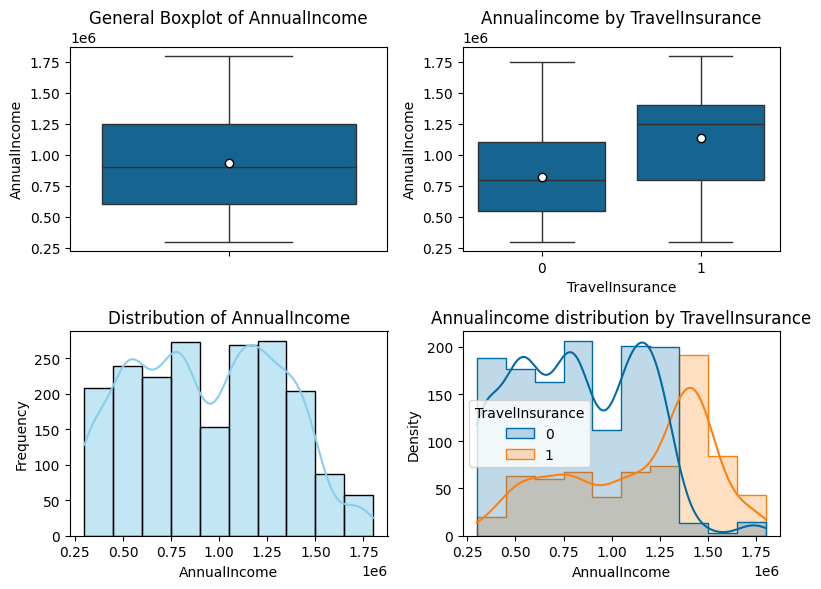

In [6]:
plot_distribution_numerical(df, "AnnualIncome")

Annual income minimum 300.000 rupees, maximum 1.800.000, mean 932.763. No outliers. No noticeable anomalies.
Buyers have higher mean and median income. Annual income distribusion for buyers are left skewed. There is a noticeable income threshold around 1.35 million rupees, where the proportion of buyers significantly increases.

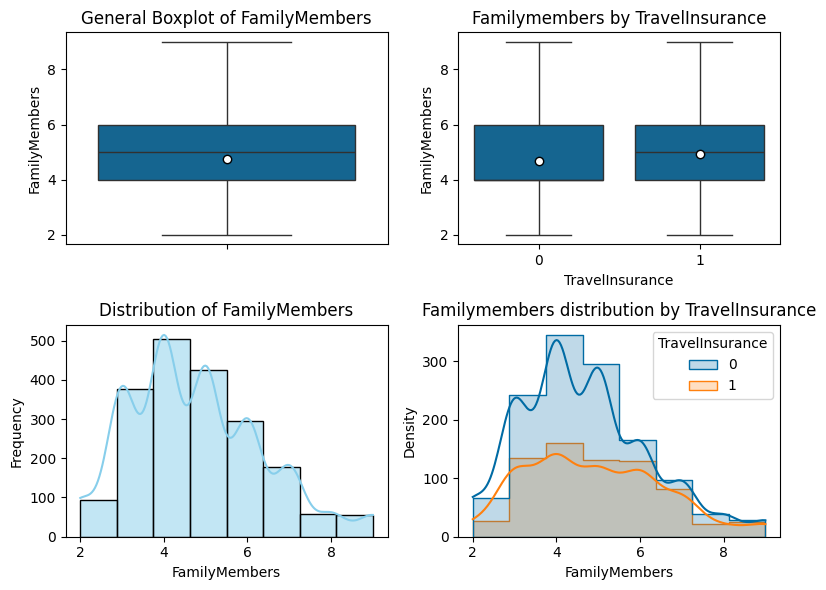

In [7]:
plot_distribution_numerical(df, "FamilyMembers", bins=8)

Family members distribusions (for buyers and non-buyers) are close to normal, righ skewed , minimum 2 members, maximum 9, mean 4,75. No outliers. No noticeable anomalies.
Customers with 6 or more family members demonstrate a higher propensity to purchase travel insurance than those with 3-5 family members.

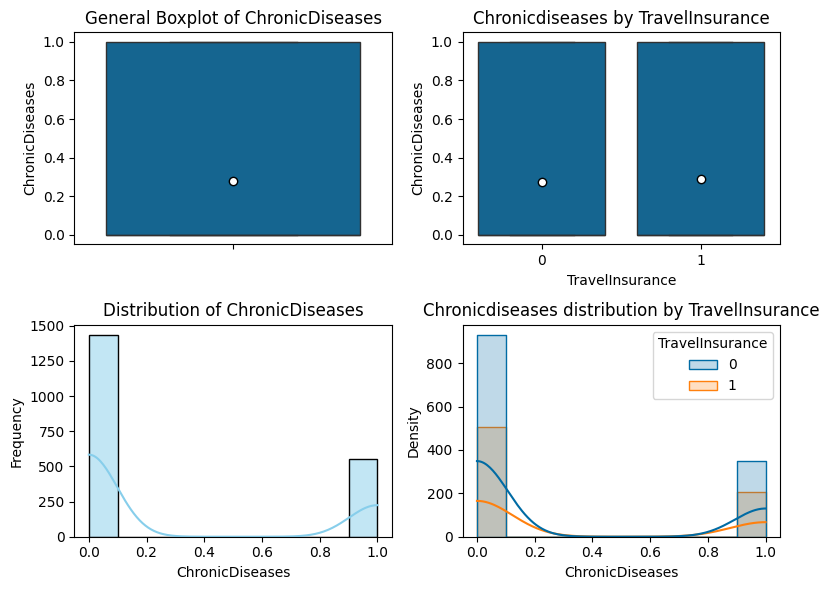

In [8]:
plot_distribution_numerical(df, "ChronicDiseases")

The 'ChronicDiseases' distribution and mean are quite close for both buyers and non-buyers, which suggests that this feature does not have a strong impact on insurance purchase

**Countplots for categorical features**

In [22]:
df["Employment Type"].value_counts(normalize=True)

Employment Type
Private Sector/Self Employed    0.713135
Government Sector               0.286865
Name: proportion, dtype: float64

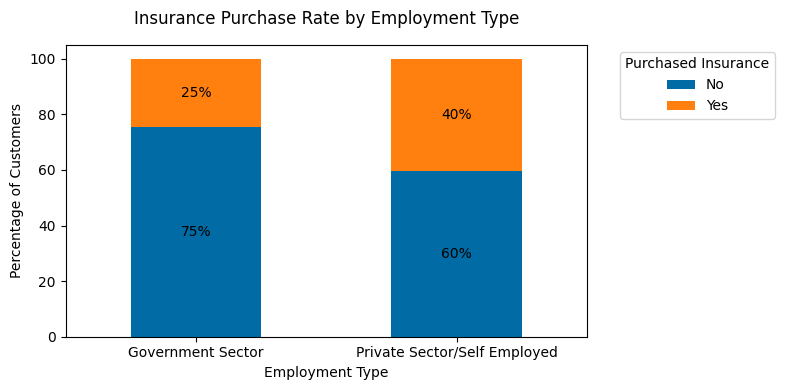

In [23]:
stacked_bar_with_percent(df, "Employment Type")

The distribution of employment type shows a clear imbalance: private sector/self employed accounts for the majority at 71.3%, while the government sector makes up only 28.7%. Customers in the Private Sector/Self-Employed category show a greater tendency to buy travel insurance than those in the Government Sector.

In [24]:
df["GraduateOrNot"].value_counts(normalize=True)

GraduateOrNot
Yes    0.851535
No     0.148465
Name: proportion, dtype: float64

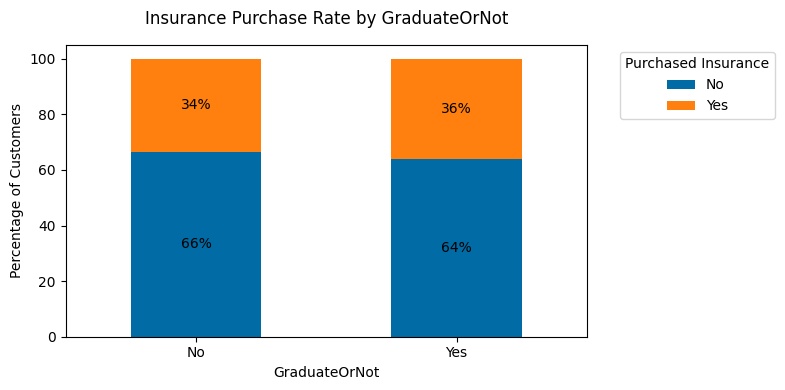

In [25]:
stacked_bar_with_percent(df, "GraduateOrNot")

The overwhelming majority of customers has higher education 85,1%. Small difference (only 2 percentage points) of travel insurance purchase rate suggests that the GraduateOrNot feature is unlikely to be a strong predictor of whether a customer will purchase travel insurance.

In [26]:
df["FrequentFlyer"].value_counts(normalize=True)

FrequentFlyer
No     0.790136
Yes    0.209864
Name: proportion, dtype: float64

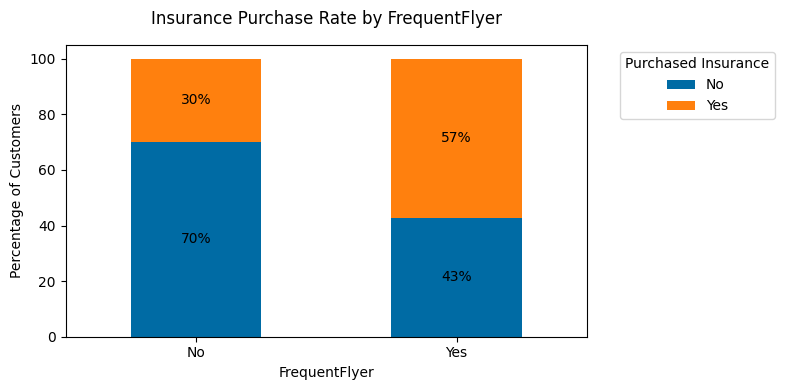

In [27]:
stacked_bar_with_percent(df, "FrequentFlyer")

Only 21 % of customers are frequent flyers, but they are almost 2 time more likely to buy travel insurance than non frequent flyers.

In [28]:
df["EverTravelledAbroad"].value_counts(normalize=True)

EverTravelledAbroad
No     0.808757
Yes    0.191243
Name: proportion, dtype: float64

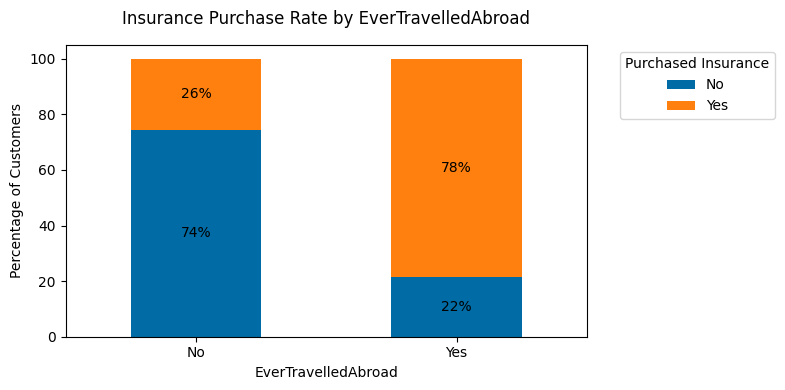

In [29]:
stacked_bar_with_percent(df, "EverTravelledAbroad")

While only 19.1% of customers have traveled abroad, they are 3 times more likely to purchase travel insurance than those who have not.

### C. Multivariate Analysis

**Phi-k Correlation matrix**

interval columns not set, guessing: ['Unnamed: 0', 'Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases', 'TravelInsurance']


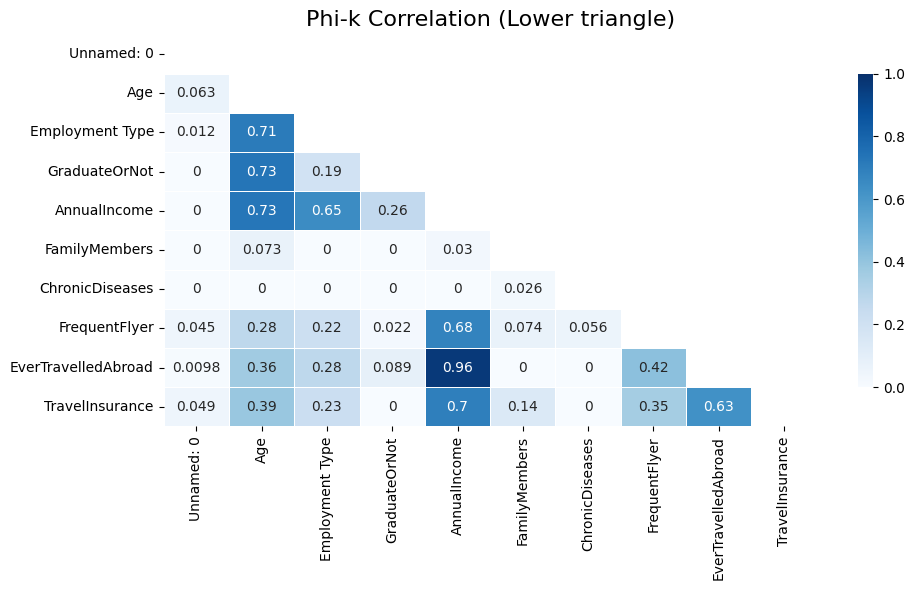

In [5]:
plot_phik_correlation_heatmap(df)

**Key Insights**

    Age, Education, and Employment are Closely Linked (≈0.7):
    Older customers are more likely to be employed in stable roles and hold graduate qualifications, reflecting a more established professional segment.
    
    Age and Income Move Together (0.73), and Employment Also Relates to Income (0.65):
    Income rises with age and employment type, making income a strong socio-economic indicator in this dataset.
    
    Income Strongly Influences Travel Behavior:
    
        - Higher-income customers travel more frequently (0.68).
        
        - International travel is almost entirely associated with higher incomes (0.96).
    
    Income and Travel Experience Drive Insurance Purchase (0.70 and 0.63):
    Customers who earn more and have traveled abroad before are far more likely to buy travel insurance.
    
    Age and Frequent Flying Have Smaller Effects (≈0.35–0.39):
    Demographics matter, but financial capacity and past travel behavior are the primary drivers of insurance uptake.

AnnualIncome has positive moderate correlation. Age, FamilyMembers, and ChronicDiseases has very weak positive correlation.

**Cross-tabulations for GraduateOrNot, FrequentFlyer, EverTravelledAbroad features**

In [31]:
crosstab_chi2_test(df, "GraduateOrNot", "TravelInsurance")


 Crosstab of GraduateOrNot vs. TravelInsurance

Normalized Crosstab (%):
TravelInsurance     0     1
GraduateOrNot              
No               66.0  34.0
Yes              64.0  36.0

Chi-squared test results:
Chi-squared Statistic: 0.6055
Degrees of Freedom: 1
P-value: 0.4365
 No significant association (p ≥ 0.05)


The Chi-squared statistic 0.6055 is small, it supports the conclusion that there is no statistical significant association dependence between the variables.
Graduates and non-graduates show close travel insurance purchase rates (36% vs 34%), suggesting education level is not a meaningful predictor.

## 3. Statistical Inference

**1. Target Population**

All potential travel insurance customers with similar characteristics to the dataset (age, income, employment type, etc.)

Sample size: The 1,987 observed customers in the dataset

We'll examine these relationships with threshold for statistical significance α = 0.05.

**2. Hypotheses testing**

**Hypothesis 1: Annual Income (Numerical) and Travel Insurance**

**Null Hypothesis (H₀):** *People who purchased travel insurance have the same mean annual income as those who didn't.*

**Alternative Hypothesis (H₁):** *The mean annual income differs between the two groups.*

- Test: Two-sample t-test
- Assumptions: Independent samples (no duplicates), approximately normal distribution or large sample, equal variances.

**Checking for normality.**

Using the Shapiro-Wilk test.

Null Hypothesis (H₀): Sample looks normal. 
Alternative Hypothesis (H₁): Sample does not look normal.

In [34]:
income_0 = df[df["TravelInsurance"] == 0]["AnnualIncome"]
income_1 = df[df["TravelInsurance"] == 1]["AnnualIncome"]

stat_yes, p_yes = shapiro(income_1)
stat_no, p_no = shapiro(income_0)

print(f"Buyers (1) - p-value: {p_yes:.4f}")
print(f"Non-Buyers (0) - p-value: {p_no:.4f}")

Buyers (1) - p-value: 0.0000
Non-Buyers (0) - p-value: 0.0000


Both p-values < 0.05: Reject H₀ - Sample does not look normal.

**Checking for equal variances.**

Null Hypothesis (H₀): The variances of annual income of people who purchased travel insurance are equal to those who did not.

Alternative Hypothesis (H₁): The variances of annual income of buyers and non-buyers are different.

In [35]:
stat, p = levene(income_0, income_1)
print(f"Levene's p-value: {p:.4f}")

Levene's p-value: 0.0000


p-value < 0.05: Reject H₀ - variances are unequal.

Distributions are not normal and variances are unequal, the assumptions for a standard two-sample t-test are violated. We should not use the regular t-test.

**Usig the Mann-Whitney U Test**

In [36]:
stat, p = mannwhitneyu(income_1, income_0, alternative="two-sided")
print(f"Mann-Whitney U Test p-value: {p:.4f}")

Mann-Whitney U Test p-value: 0.0000


P-value < 0.05. Reject H₀ - The median annual income of buyers statistically significant differs from non-buyers 

**Bootstrap CI for the median difference**

In [37]:
bootstrap_ci = bootstrap_median_diff(income_1, income_0)
print(
    f"\nBootstrap CI for the median difference (Yes - No): [{bootstrap_ci[0]:.2f}, {bootstrap_ci[1]:.2f}]"
)


Bootstrap CI for the median difference (Yes - No): [400000.00, 500000.00]


The bootstrap confidence interval for the difference in means does not includes zero, reinforcing that the difference in means is statistically significant. **These results suggest that buyers of travel insurance tend to have significantly higher annual incomes than non-buyers.**

**Hypothesis 2: Employment Type (Categorical) and Travel Insurance**

**Null Hypothesis (H₀):** *Travel insurance purchase is independent of employment type.*

**Alternative Hypothesis (H₁):** *Travel insurance purchase is associated with employment type.*

- Test: Chi-squared test of independence.

In [38]:
crosstab_chi2_test(df, "Employment Type", "TravelInsurance")


 Crosstab of Employment Type vs. TravelInsurance

Normalized Crosstab (%):
TravelInsurance                  0     1
Employment Type                         
Government Sector             75.0  25.0
Private Sector/Self Employed  60.0  40.0

Chi-squared test results:
Chi-squared Statistic: 42.7538
Degrees of Freedom: 1
P-value: 0.0000
 Statistically significant association (p < 0.05)


Chi-squared Statistic: 42.8 - suggesting a moderate deviation from independence.
P-value < 0.05 **indicates a statistically significant association between a customer's employment type and their decision to purchase travel insurance.** 

**Hypothesis 3: Chronic Diseases Effect**

**Null Hypothesis (H₀):** *Chronic disease status doesn't affect purchase rate.*

**Alternative Hypothesis (H₁):** *Chronic diseases increase purchase likelihood.*

- Test: ztest.

**Checking for sample size**

Both feature and target are binary (0/1), we do not need to check for normality in the usual sense  we check if the sample size is large enough for the normal approximation to be valid (bigger than 5)

In [39]:
grouped = df.groupby("ChronicDiseases")["TravelInsurance"].agg(["sum", "count"])

grouped.columns = ["num_bought", "total"]
grouped["proportion"] = grouped["num_bought"] / grouped["total"]

grouped["n*p"] = grouped["total"] * grouped["proportion"]
grouped["n*(1-p)"] = grouped["total"] * (1 - grouped["proportion"])
grouped["z_test_valid"] = (grouped["n*p"] >= 5) & (grouped["n*(1-p)"] >= 5)

print(grouped)

                 num_bought  total  proportion    n*p  n*(1-p)  z_test_valid
ChronicDiseases                                                             
0                       505   1435    0.351916  505.0    930.0          True
1                       205    552    0.371377  205.0    347.0          True


**Z-test**

In [40]:
grouped = df.groupby("ChronicDiseases")["TravelInsurance"].agg(["sum", "count"])
n_successes = grouped["sum"].values
n_obs = grouped["count"].values

z_stat, p_val = proportions_ztest(count=n_successes, nobs=n_obs)
print(f"Z-statistic: {z_stat:.3f}, p-value: {p_val:.4f}")

ci_group_0 = proportion_confint(
    count=grouped.loc[0, "sum"], nobs=grouped.loc[0, "count"], alpha=0.05
)
ci_group_1 = proportion_confint(
    count=grouped.loc[1, "sum"], nobs=grouped.loc[1, "count"], alpha=0.05
)
p0 = grouped.loc[0, "sum"] / grouped.loc[0, "count"]
p1 = grouped.loc[1, "sum"] / grouped.loc[1, "count"]
print(f"Proportion with insurance (No Chronic Diseases): {p0:.3f}")
print(f"Proportion with insurance (With Chronic Diseases): {p1:.3f}")

print(f"Group 0 (No Chronic Diseases) CI: ({ci_group_0[0]:.3f}, {ci_group_0[1]:.3f})")
print(f"Group 1 (With Chronic Diseases) CI: ({ci_group_1[0]:.3f}, {ci_group_1[1]:.3f})")

Z-statistic: -0.811, p-value: 0.4175
Proportion with insurance (No Chronic Diseases): 0.352
Proportion with insurance (With Chronic Diseases): 0.371
Group 0 (No Chronic Diseases) CI: (0.327, 0.377)
Group 1 (With Chronic Diseases) CI: (0.331, 0.412)


P-value > 0.05, fail to reject the null hypothesis. There is no statistically significant difference in travel insurance purchase rates between customers with and without chronic diseases

Since the confidence intervals overlap substantially, this again suggests that the difference in proportions is not statistically significant. **Chronic disease status has no statistically significant relation to travel insurance decisions in the dataset.**

**Key insights**

    Statistical tests reveal that customers who purchased travel insurance tend to have significantly higher annual incomes. 
    
    Employment type is also significantly associated with insurance purchase decisions. 
    
    However, the presence of chronic diseases does not show a statistically significant impact on the likelihood of buying travel insurance.

## 4. Machine Learning Modeling

### A. Data Preparation

To avoid data leakage, we will re-import the dataframe

In [41]:
df = pd.read_csv(r"Data\TravelInsurancePrediction.xls")
df = df.drop(columns="Unnamed: 0")
print(f"{ df.shape}, {df.duplicated().sum()}\n{df.isna().sum()}")

(1987, 9), 738
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64


Instead of splitting the data into train, validation, and test sets, I will split it into train and test sets, and use cross-validation on the training set

In [42]:
X = df.drop("TravelInsurance", axis=1)
y = df["TravelInsurance"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

Train: 1589 samples, Test: 398 samples


### B. Pipeline Preprocessing 

As the dataset has no NaN values, SimpleImputer will be skipped. Categorical features will be handled with OneHotEncoder, and numerical features with StandardScaler.

In [43]:
categorical = X.select_dtypes(include="object").columns.tolist()
numerical = X.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    [("num", num_pipe, numerical), ("cat", cat_pipe, categorical)]
)

### C. Model Selection

We will use LogisticRegression, Random Forest, Hist Gradient Boosting, SVM models.

Logistic Regression is a simple and interpretable linear model used for binary classification that estimates the probability of class membership using a logistic function.

Random Forest is an ensemble of decision trees that improves accuracy by averaging multiple trees trained on bootstrapped samples, reducing overfitting and handling non-linear relationships well.

Hist Gradient Boosting is a fast, scalable boosting algorithm that builds trees sequentially to correct previous errors, using histogram binning for efficient training on large datasets.

Support Vector Machine (SVM) finds the optimal hyperplane that maximizes the margin between classes, effective in high-dimensional spaces and can handle non-linear data via kernel functions.





In [78]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(),
    "SVM": SVC(probability=True, class_weight="balanced"),
}

Results for default models (before hyperparameters tuning).

In [79]:
detailed_reports = {}

for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

    report = classification_report(y_train, y_pred, output_dict=True)
    detailed_reports[name] = pd.DataFrame(report).transpose()
    print(f"=== {name} === \n{classification_report(y_train, y_pred)}")

=== Logistic Regression === 
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1021
           1       0.63      0.63      0.63       568

    accuracy                           0.73      1589
   macro avg       0.71      0.71      0.71      1589
weighted avg       0.73      0.73      0.73      1589

=== Random Forest === 
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1021
           1       0.69      0.64      0.66       568

    accuracy                           0.77      1589
   macro avg       0.75      0.74      0.75      1589
weighted avg       0.77      0.77      0.77      1589

=== Hist Gradient Boosting === 
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1021
           1       0.83      0.62      0.71       568

    accuracy                           0.82      1589
   macro avg       0.82      0.78      0.79 

Key metrics for the goal - accurately identifying customers who will buy travel insurance:
1. Recall (Class 1: Buyers) o	Missing buyers directly impacts revenue and fails the project’s purpose.
2. Precision (Class 1: Buyers) o	High precision ensures marketing efforts aren’t wasted on non-buyers
3. F1-Score (Class 1) Balances precision and recall. 

Hist Gradient Boosting shows the best overall performance in identifying buyers, achieving the highest F1-score (0.71) and precision (0.83), making it ideal when both minimizing false positives and capturing actual buyers is important.
Random Forest slightly outperforms Logistic Regression and SVM in recall but trails behind Gradient Boosting in precision and F1.
SVM performs comparably in precision but falls short in recall compared to Random Forest.
Logistic Regression has the lowest scores across all key metrics, indicating limited effectiveness for this task.

### D. Hyperparameter Tuning 

Defining hyperparameter grids for each model. Run RandomizedSearchCV. Predict on train set using the best estimator. 

In [80]:
param_distributions = {
    "Logistic Regression": {
        "classifier__C": uniform(0.01, 100),
        "classifier__penalty": ["l2"],
        "classifier__solver": ["lbfgs", "liblinear"],
    },
    "Random Forest": {
        "classifier__n_estimators": randint(50, 200),
        "classifier__max_depth": randint(3, 10),
        "classifier__min_samples_split": randint(2, 20),
    },
    "Hist Gradient Boosting": {
        "classifier__max_iter": randint(50, 200),
        "classifier__learning_rate": uniform(0.01, 0.3),
        "classifier__max_depth": randint(3, 8),
    },
    "SVM": {
        "classifier__C": uniform(0.1, 10),
        "classifier__kernel": ["linear", "rbf"],
        "classifier__gamma": ["scale", "auto"],
    },
}

In [81]:
best_models = {}

for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    search = RandomizedSearchCV(
        pipe,
        param_distributions[name],
        n_iter=20,
        cv=5,
        scoring="roc_auc",
        random_state=42,
        n_jobs=-1,
    )

    print(f"\n=== Tuning {name} ===")
    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_

    print(f"Best params: {search.best_params_}")
    print(f"Best CV ROC-AUC: {search.best_score_:.3f}")

    y_pred_tuned = search.best_estimator_.predict(X_train)

    print(f"\n=== {name} - Tuned ===")
    print(classification_report(y_train, y_pred_tuned))


=== Tuning Logistic Regression ===
Best params: {'classifier__C': 0.08787658410143283, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV ROC-AUC: 0.764

=== Logistic Regression - Tuned ===
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1021
           1       0.62      0.62      0.62       568

    accuracy                           0.73      1589
   macro avg       0.71      0.71      0.71      1589
weighted avg       0.73      0.73      0.73      1589


=== Tuning Random Forest ===
Best params: {'classifier__max_depth': 9, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 130}
Best CV ROC-AUC: 0.811

=== Random Forest - Tuned ===
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1021
           1       0.95      0.67      0.79       568

    accuracy                           0.87      1589
   macro avg       0.89      0.83      0.85     

Logistic Regression - Tuned: Basic baseline model with limited ability to identify buyers. High risk of missing them.

Random Forest - Tuned:

Recall (0.67): Identifies 67% of buyers — a noticeable improvement.

Precision (0.95): Very high — almost all predicted buyers actually buy, reducing wasted outreach.

F1-score (0.79): Strong balance; the best among all models.

Accuracy (0.87): Highest between models.

CV ROC-AUC (0.811): Slightly lower than Hist Gradient Boosting.

Conclusion: Best overall model — excellent at precision, and reasonably strong at recall. Ideal when avoiding false positives and still catching many buyers is key.

Hist Gradient Boosting - Tuned: A strong model, especially in precision, but recall is a bit weaker — some buyers will be missed.

SVM - Tuned: A solid performer, but outperformed by Random Forest and Gradient Boosting.

**Comparing metrics before and after hyperparameter tuning.**

Creating dataframe for metrcis.

In [89]:
results = []

for name, report_df in detailed_reports.items():
    precision = report_df.loc["1", "precision"]
    recall = report_df.loc["1", "recall"]
    f1 = report_df.loc["1", "f1-score"]
    acc = report_df.loc["accuracy", "f1-score"]

    try:
        proba = models[name].predict_proba(X_train)[:, 1]
        roc_auc = roc_auc_score(y_train, proba)
    except:
        roc_auc = None

    results.append(
        {
            "Model": name,
            "Type": "Default",
            "Precision (C1)": precision,
            "Recall (C1)": recall,
            "F1 (C1)": f1,
            "Accuracy": acc,
            "ROC-AUC": roc_auc,
        }
    )

for name, model in best_models.items():
    y_pred = model.predict(X_train)
    y_proba = (
        model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    )

    acc = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, pos_label=1)
    recall = recall_score(y_train, y_pred, pos_label=1)
    f1 = f1_score(y_train, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_train, y_proba) if y_proba is not None else None

    results.append(
        {
            "Model": name,
            "Type": "Tuned",
            "Precision (C1)": precision,
            "Recall (C1)": recall,
            "F1 (C1)": f1,
            "Accuracy": acc,
            "ROC-AUC": roc_auc,
        }
    )

metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.sort_values(by=["Model", "Type"]).reset_index(drop=True)
metrics_df

,Model,Type,Precision (C1),Recall (C1),F1 (C1),Accuracy,ROC-AUC
0,Hist Gradient Boosting,Default,0.825581,0.625000,0.711423,0.818754,NaN
1,Hist Gradient Boosting,Tuned,0.939891,0.605634,0.736617,0.845186,0.901539
2,Logistic Regression,Default,0.625219,0.628521,0.626866,0.732536,NaN
3,Logistic Regression,Tuned,0.624339,0.623239,0.623789,0.731278,0.770590
4,Random Forest,Default,0.694818,0.637324,0.664830,0.770296,NaN
5,Random Forest,Tuned,0.945545,0.672535,0.786008,0.869100,0.937160
6,SVM,Default,0.792711,0.612676,0.691162,0.804279,NaN
7,SVM,Tuned,0.855792,0.637324,0.730575,0.831970,0.840726


**Ploting results for specific model.**

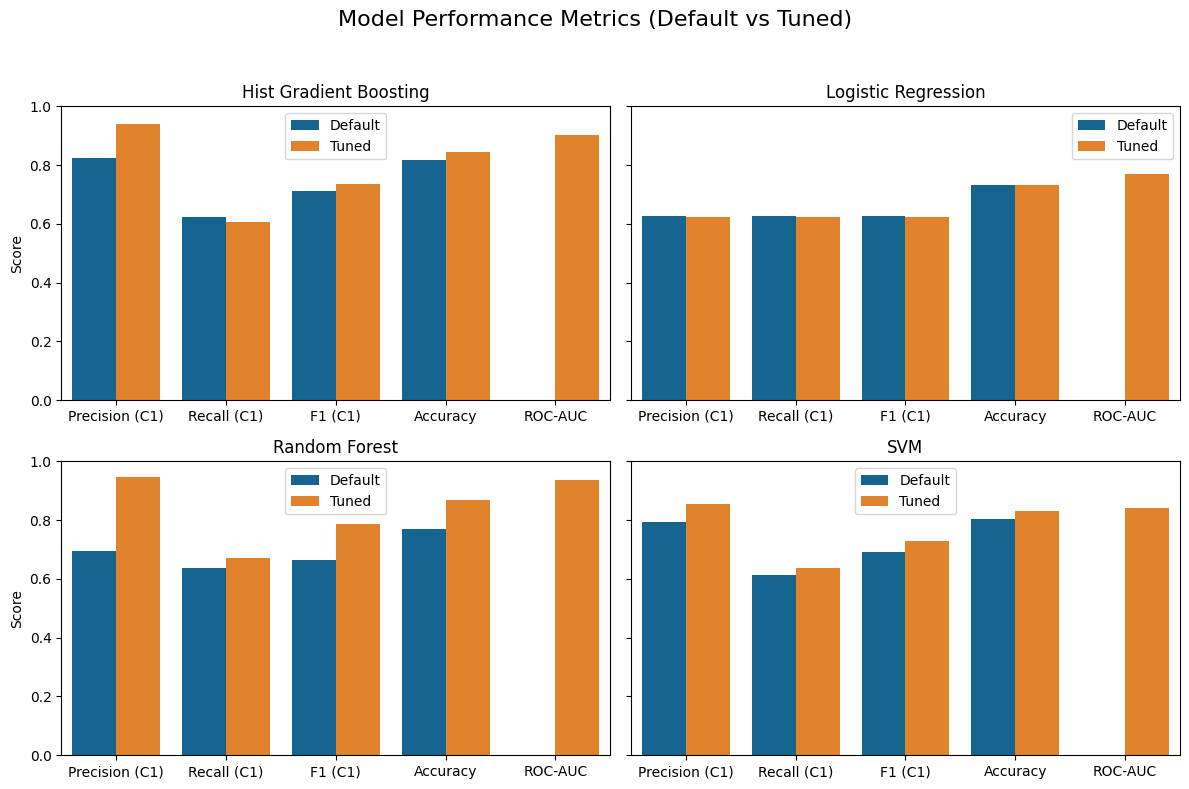

In [90]:
metrics_long = metrics_df.melt(
    id_vars=["Model", "Type"],
    value_vars=[
        "Precision (C1)",
        "Recall (C1)",
        "F1 (C1)",
        "Accuracy",
        "ROC-AUC",
    ],
    var_name="Metric",
    value_name="Value",
)

models = metrics_long["Model"].unique()

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    data = metrics_long[metrics_long["Model"] == model]
    sns.barplot(data=data, x="Metric", y="Value", hue="Type", ax=ax)
    ax.set_title(model)
    ax.set_ylim(0, 1)
    ax.set_xlabel("")
    ax.set_ylabel("Score")
    ax.tick_params(axis="x")
    ax.legend().set_title("")

plt.suptitle("Model Performance Metrics (Default vs Tuned)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Logistic Regression: Minimal change, even slighty worse after tuning.

Random Forest: Major improvement in Precision (C1), other metrics also improved.

Hist Gradient Boosting: Strong improvement in Precision (C1), decrease in Recall (C1).

SVM: Modest gains in all key metrics; but wors than Random forest.

**Comparing Precision (C1) and Recall (C1) metrics for models.**

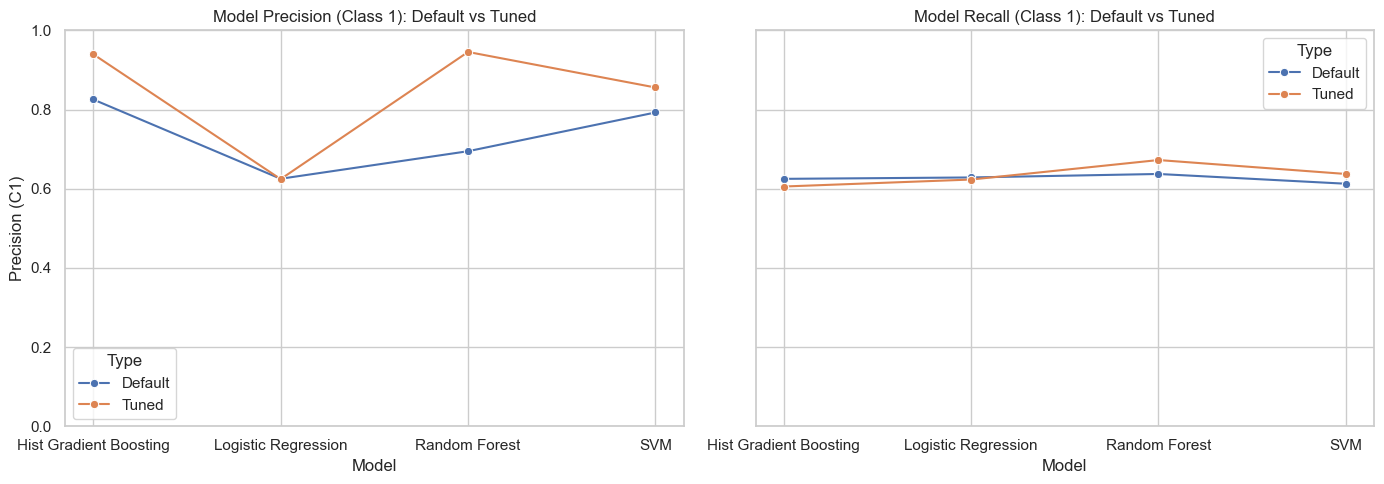

In [92]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.lineplot(
    data=metrics_df, x="Model", y="Precision (C1)", hue="Type", marker="o", ax=axes[0]
)
axes[0].set_title("Model Precision (Class 1): Default vs Tuned")
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis="x")

sns.lineplot(
    data=metrics_df, x="Model", y="Recall (C1)", hue="Type", marker="o", ax=axes[1]
)
axes[1].set_title("Model Recall (Class 1): Default vs Tuned")
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis="x")
plt.tight_layout()

Precision (Class 1):
- major improvement for Random forest model,
- improved Hist Gradient Boosting and SVM models,
- almost the same Logistic regresion model.

Recall (Class 1):
- improvement for Random forest and SVM models,
- decreased for  Hist Gradient Boosting and Logistic regresion models.

### E. Ensembling

We will choose two best performed models after hyperparameter tuning: Random Forest and Hist Gradient Boosting.

In [93]:
top_models = {
    "rf": best_models["Random Forest"],
    "hgb": best_models["Hist Gradient Boosting"],
}

ensemble = VotingClassifier(estimators=list(top_models.items()), voting="soft")
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Age',
                                                                                 'AnnualIncome',
                                                                                 'FamilyMembers',
                                                                                 'ChronicDiseases']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['Employment '
                                                                                 'Type',
                                                                                 'GraduateOrNot',
                                                                                 'FrequentFlyer',
                                                                                 'EverTravelle...
                                                                                                 StandardScaler())]),
                                                                                ['Age',
                                                                                 'AnnualIncome',
                                                                                 'FamilyMembers',
                                                                                 'ChronicDiseases']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['Employment '
                                                                                 'Type',
                                                                                 'GraduateOrNot',
                                                                                 'FrequentFlyer',
                                                                                 'EverTravelledAbroad'])])),
                                              ('classifier',
                                               HistGradientBoostingClassifier(learning_rate=0.05286004537658223,
                                                                              max_depth=5,
                                                                              max_iter=199))]))],
                 voting='soft')

**Cross-validation on the ensemble.**

In [94]:
cv_auc_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring="roc_auc")
print(f"Mean CV ROC-AUC: {cv_auc_scores.mean():.4f}")

ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_train)
print(classification_report(y_train, y_pred_ensemble))

Mean CV ROC-AUC: 0.8153
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1021
           1       0.94      0.64      0.76       568

    accuracy                           0.86      1589
   macro avg       0.88      0.81      0.83      1589
weighted avg       0.87      0.86      0.85      1589



**Comparing cross-validation ensemble vs random forest model.**

In [95]:
for name, model in best_models.items():
    if name == "Random Forest":
        y_pred_tuned = model.predict(X_train)
        print(f"Best CV ROC-AUC: {search.best_score_:.3f}")
        print(f"\n=== {name} - Tuned ===")
        print(classification_report(y_train, y_pred_tuned))

Best CV ROC-AUC: 0.802

=== Random Forest - Tuned ===
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1021
           1       0.95      0.67      0.79       568

    accuracy                           0.87      1589
   macro avg       0.89      0.83      0.85      1589
weighted avg       0.88      0.87      0.86      1589



Tuned Random Forest slightly outperforms the Ensemble in all key metrics: precision, recall, F1-score for Class 1, and overall accuracy.

Ensemble has a marginally better cross-validated ROC-AUC, suggesting more stable probabilistic predictions during training.

### F. Models evaluation on Test set

Comparing evaluation of ensemble and Random forest model.

In [96]:
y_pred_ensemble = ensemble.predict(X_test)
y_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]
report_ensemble = classification_report(y_test, y_pred_ensemble)
roc_auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)

print("=== Ensemble Random Forest and Hist Gradient Boosting ===")
print(report_ensemble)
print(f"ROC-AUC: {roc_auc_ensemble:.4f}")

rf_model = best_models["Random Forest"]

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
report_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print("\n=== Random Forest (Tuned) ===")
print(report_rf)
print(f"ROC-AUC: {roc_auc_rf:.4f}")

=== Ensemble Random Forest and Hist Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       256
           1       0.89      0.57      0.70       142

    accuracy                           0.82       398
   macro avg       0.85      0.77      0.78       398
weighted avg       0.83      0.82      0.81       398

ROC-AUC: 0.7805

=== Random Forest (Tuned) ===
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       256
           1       0.86      0.58      0.69       142

    accuracy                           0.82       398
   macro avg       0.83      0.76      0.78       398
weighted avg       0.82      0.82      0.81       398

ROC-AUC: 0.7576


Ensemble model slightly outperforms the Tuned Random Forest in most key metrics for buyers: precision, F1-score, and ROC-AUC.

Recall for buyers is nearly identical in both models (~0.57–0.58), indicating both have room for improvement in catching all potential buyers.

Accuracy is the same for both at 0.82.

Ensemble model shows a slight edge on the test set and would be the better choice.

**Normalized Confusion matrix for ensemble**

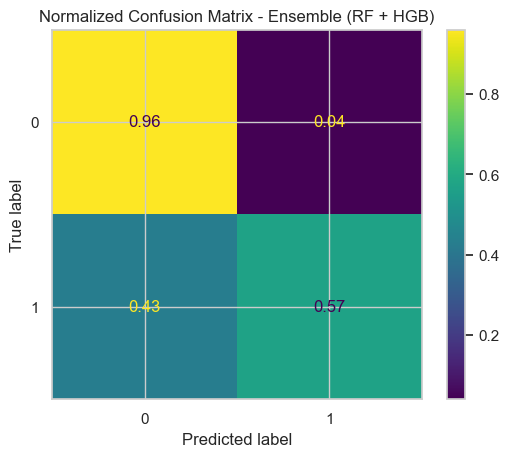

In [97]:
cm = confusion_matrix(y_test, y_pred_ensemble, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble.classes_)
disp.plot(values_format=".2f")  # format to 2 decimals

plt.title("Normalized Confusion Matrix - Ensemble (RF + HGB)")
plt.show()

True class 0 (No Insurance):

    96% were correctly classified as 0.

    Only 4% were misclassified as 1.

    This indicates strong performance for the majority class (Class 0).

True class 1 (Bought Insurance):

    57% were correctly classified as 1.

    53% were misclassified as 0.

    The model struggles to detect Class 1, which is critical since missing buyers undermines the business goal.

While performance on non-buyers is excellent, the model underperforms where it matters most: identifying likely buyers.


**ROC Curves for Ensemble and Random forest.**

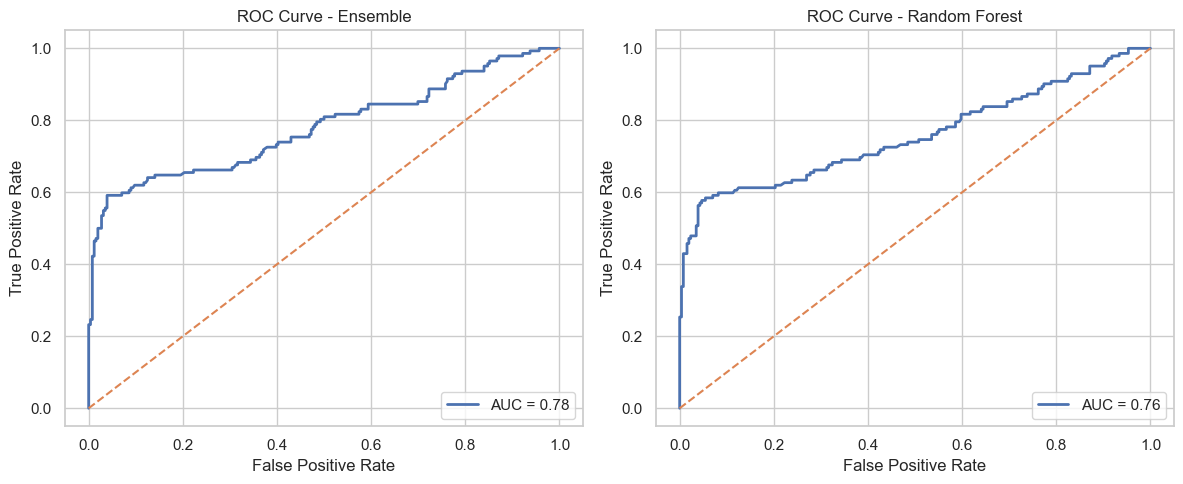

In [98]:
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_proba_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(
    fpr_ensemble,
    tpr_ensemble,
    lw=2,
    label=f"AUC = {roc_auc_ensemble:.2f}",
)
axes[0].plot([0, 1], [0, 1], linestyle="--")
axes[0].set_title("ROC Curve - Ensemble")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")
axes[0].grid(True)

axes[1].plot(fpr_rf, tpr_rf, lw=2, label=f"AUC = {roc_auc_rf:.2f}")
axes[1].plot([0, 1], [0, 1], linestyle="--")
axes[1].set_title("ROC Curve - Random Forest")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()

Both models perform significantly better than random (0.5), with decent separation ability.

The Ensemble model (0.78) has a slightly better ability to rank positive cases (buyers) higher than negative ones compared to the Random Forest (0.76).

**Decision boundary Random forest**

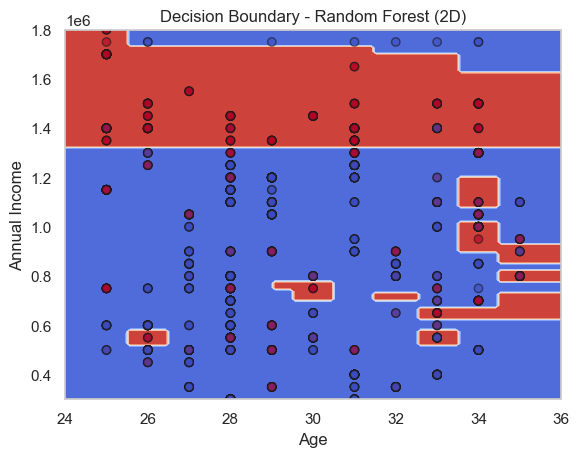

In [100]:
X_2d = X_train[["Age", "AnnualIncome"]].copy()

rf_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2d.fit(X_2d, y_train)

DecisionBoundaryDisplay.from_estimator(
    rf_2d, X_2d, response_method="predict", cmap="coolwarm"
)
plt.scatter(
    X_2d["Age"],
    X_2d["AnnualIncome"],
    c=y_train,
    edgecolor="k",
    cmap="coolwarm",
    alpha=0.6,
)
plt.xlabel("Age")
plt.ylabel("Annual Income")
plt.title("Decision Boundary - Random Forest (2D)")
plt.show()

The decision boundaries for the Random Forest model appear to be primarily influenced by the Annual Income feature, as shown by a nearly vertical boundary around 1.35 to 1.6-1.8 million rupees. This suggests that income plays a dominant role in the model's decision-making.

Additionally, there is a noticeable region—an "island" of positive predictions—for customers aged 33 to 35 years, indicating that the model is more likely to predict "yes" (e.g., travel insurance purchase) for individuals in this age range, particularly if their income is within a certain band.

### G. Feature Importance Analysis

Random forest model.

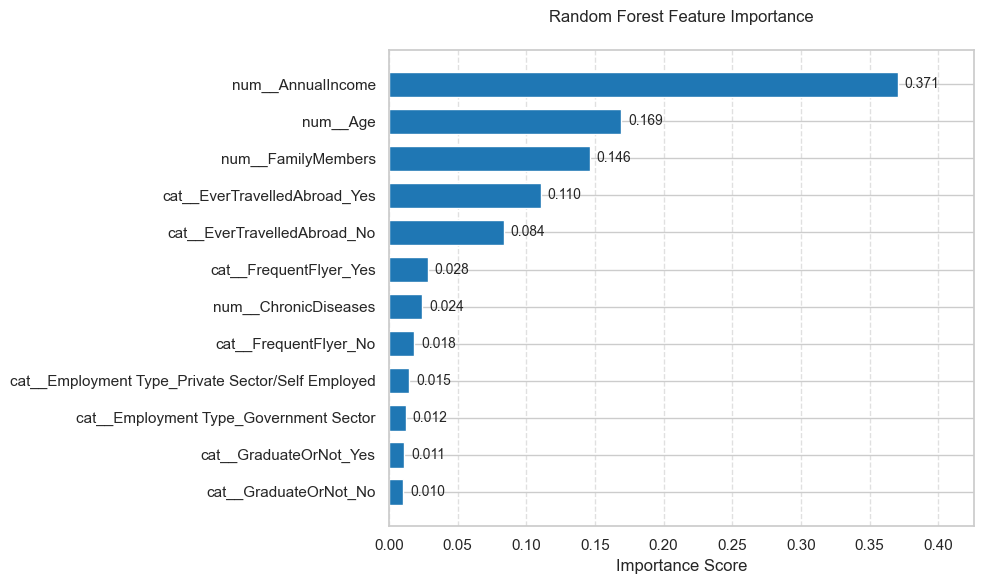

In [101]:
rf_model = best_models["Random Forest"].named_steps["classifier"]

try:
    feature_names = (
        best_models["Random Forest"].named_steps["preprocessor"].get_feature_names_out()
    )
except AttributeError:
    feature_names = X_train.columns

importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    range(len(sorted_idx)),
    importances[sorted_idx],
    align="center",
    color="#1f77b4",
    height=0.7,
)

for i, (importance, feature) in enumerate(
    zip(importances[sorted_idx], [feature_names[i] for i in sorted_idx])
):
    plt.text(
        importance + 0.005,
        i,
        f"{importance:.3f}",
        ha="left",
        va="center",
        fontsize=10,
    )

plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("Random Forest Feature Importance", pad=20)
plt.xlabel("Importance Score")
plt.xlim(0, max(importances) * 1.15)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

1. Annual Income (0.371) - The Dominant Factor

    37.1% of the model's decisions are driven by income.

    Practical meaning: Customers with higher incomes are far more likely to buy insurance.

2. Age (0.169) - Moderate Influence

    16.9% importance, suggesting younger/older customers behave differently.

3. Family Members (0.146)

    14.6% importance, implying larger families slightly more likely to buy.

4. Travel Experience

   11.1% importance for Yes.

   8.4% importance for No.

Key Takeaways

    Income is number 1 lever for predicting purchases.
    
    Age/family size are secondary but useful for segmentation.
    
    Travel experience matters.

## 5. Conclusion

Key Findings:

    1. Best Performing Model:
    
        After hyperparameter tuning and comparison, the Random Forest model showed the best performance with:

        Precision (0.95): Very high — almost all predicted buyers actually buy, reducing wasted outreach.

        Recall (0.67): Identifies 67% of buyers.

        F1-score (0.79): Strong balance.

        Accuracy (0.87): Highest between models.

        CV ROC-AUC (0.811): Slightly lower than Hist Gradient Boosting.

    2. Ensemble Advantage:

        Ensemble model (Random Forest + Hist Gradient Boostings) shows a slight edge on the test set and would be the best choice. 
    
    3. Important Predictors (Random Forest):

        Annual Income was the most decisive feature in both the model and decision boundaries.

        Age and Family members also contributed significantly to prediction.

        Customers around 1.3–1.7 million rupees income and ages 33–35 showed high purchase likelihood.

    4. Model Evaluation:

        Applied cross-validation, confusion matrices, ROC curves, and decision boundaries to ensure model robustness and interpretability.

Business Recommendations:

    1. Targeted Marketing:

        Focusing travel insurance marketing on customers with middle to high income and aged 30–40, especially frequent flyers.

        Using predictions to tailor offers to likely buyers while reducing outreach to unlikely buyers to save marketing cost.

        For families, offering group discounts.

    2. Customer Profiling:

        Creating segments based on income and travel frequency for customized communication and retention strategies.

Suggestions for Improvement:

    Feature Engineering:

        Including travel history, past insurance purchase behavior, or trip purpose if available.

        Deriving new features like income per household member or age buckets.

    Data Balancing:

        Trying resampling techniques (oversampling minority class or undersampling majority class) to improve recall for the "Yes" class.

    Model Exploration:

        Testing additional algorithms like XGBoost, or CatBoost for potentially better performance and faster training.